In [3]:
import glob, cv2
import numpy as np
import os

In [734]:


# Define the charuco board parameters
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
charuco_board = cv2.aruco.CharucoBoard((5, 7), 0.04, .02, dictionary)
params = cv2.aruco.DetectorParameters()
params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_NONE

# Define circle grid points in 2D
nb_col = 4
nb_row = 11
circle_r = 20
default_x, default_y = (800, 400)

circle_2d_pts = np.zeros((nb_col*nb_row, 2), dtype=np.int32)
count = 0
for i in range(nb_row):
    for j in range(nb_col-1, -1, -1):
        if i % 2 == 0:
            pos_x = j * 6 * circle_r + (3 * circle_r)
        else:
            pos_x = j * 6 * circle_r 
        pos_y = i * 3 * circle_r
        circle_2d_pts[count] = [pos_x, pos_y]
        count += 1
circle_2d = circle_2d_pts + [default_x, default_y]

In [33]:
def remove_dist(img, k, dist):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(k, dist, (w,h), 1, (w,h))
    dst = cv2.undistort(img, k, dist, None, newcameramtx)
    x, y, w, h = roi
    return dst[y:y+h, x:x+w]

def detect_markers(frame, gray, k, dist, dictionary, params, draw=True):
    rvec = None
    tvec = None
    ret = False

    # Detect markers and corners
    corners, ids, rejected = cv2.aruco.detectMarkers(gray, dictionary, parameters=params)

    if corners is not None and len(corners) > 0:
        if draw:
            frame = cv2.aruco.drawDetectedMarkers(frame, corners, ids)
        ret, charuco_corners, charuco_ids = cv2.aruco.interpolateCornersCharuco(corners, ids, frame, charuco_board)
        if charuco_ids is not None and len(charuco_ids) > 0:
            if draw:
                frame = cv2.aruco.drawDetectedCornersCharuco(frame, charuco_corners, charuco_ids)
            ret, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(charuco_corners, charuco_ids, charuco_board, k, dist, None, None)
            if ret and draw:
                frame = cv2.drawFrameAxes(frame, k, dist, rvec, tvec, 0.1)

    return ret, frame, rvec, tvec

In [742]:
def fromCamToWorld(cameraMatrix, distCoeff, rV, tV, imgPoints):
    s = len(imgPoints)
    invK = np.linalg.inv(cameraMatrix)
    #imgPoints = cv2.undistortPoints(imgPoints, cameraMatrix, distCoeff)
    r = rV.astype(np.float32)
    t = tV.astype(np.float32)
    rMat, _ = cv2.Rodrigues(r)
    transPlaneToCam = np.linalg.inv(rMat) @ t
    world_points = []
    for i in range(s):
        wpTemp = []
        s2 = len(imgPoints[i])
        for j in range(s2):
            coords = np.array([[imgPoints[i][j][0]], [imgPoints[i][j][1]], [1.0]], dtype=np.float32)
            
            worldPtCam = invK @ coords
            worldPtPlane = np.linalg.inv(rMat) @ worldPtCam

            scale = (transPlaneToCam[2] / worldPtPlane[2])[0]
            worldPtPlaneReproject = scale * worldPtPlane - transPlaneToCam
            

            pt = np.array([worldPtPlaneReproject[0][0], worldPtPlaneReproject[1][0], 0], dtype=np.float32)
            wpTemp.append(pt)

        world_points.append(wpTemp)
    return np.array(world_points, dtype=np.float32)[:, 0, :]

# Took from https://www.morethantechnical.com/blog/2017/11/17/projector-camera-calibration-the-easy-way/
def intersectCirclesRaysToBoard(circles, rvec, t, K, dist_coef):
    circles_normalized = cv2.convertPointsToHomogeneous(cv2.undistortPoints(circles, K, dist_coef))
    if not rvec.size:
        return None
    R, _ = cv2.Rodrigues(rvec)
    # https://stackoverflow.com/questions/5666222/3d-line-plane-intersection
    plane_normal = R[2,:] # last row of plane rotation matrix is normal to plane
    plane_point = t.T     # t is a point on the plane
    epsilon = 1e-06
    circles_3d = np.zeros((0,3), dtype=np.float32)
    for p in circles_normalized:
        ray_direction = p / np.linalg.norm(p)
        ray_point = p
        ndotu = plane_normal.dot(ray_direction.T)
        if abs(ndotu) < epsilon:
            print ("no intersection or line is within plane")
        w = ray_point - plane_point
        si = -plane_normal.dot(w.T) / ndotu
        Psi = w + si * ray_direction + plane_point
        circles_3d = np.append(circles_3d, Psi, axis = 0)
    return circles_3d

def detect_circle_grid(frame, gray, k, dist, shape, rvec, tvec, draw=True):
    ret, circles = cv2.findCirclesGrid(gray, shape, flags=cv2.CALIB_CB_ASYMMETRIC_GRID + cv2.CALIB_CB_CLUSTERING)
    
    world_pts = None
    circles3D = None
    if ret:
        if draw:
            frame = cv2.drawChessboardCorners(frame, shape, circles, ret)
        # ray-plane intersection: circle-center to chessboard-plane
        circles3D = intersectCirclesRaysToBoard(circles, rvec, tvec, k, dist)
        for i in range(len(circles3D)):
            circles3D[i] = circles3D[i] / circles3D[i][2]
            circles3D[i][2] = 0

        world_pts = fromCamToWorld(k, dist, rvec, tvec, circles)

        # re-project on camera for verification
        circles3D_reprojected, _ = cv2.projectPoints(circles3D, (0,0,0), (0,0,0), k, dist)

        if draw:
            for c in circles3D_reprojected:
                frame = cv2.circle(frame, tuple(c.astype(np.int32)[0]), 5, (255,255,0), cv2.FILLED)
    return ret, frame, circles, circles3D.astype(np.float32)

In [765]:
# Get previous calibration data for the camera
cam_mtx = np.load('data/mtx.npy')
cam_dist = np.load('data/dist.npy')

obj_pts = []
proj_circle_pts = []
cam_circle_pts = []
calibration_folder = './calibration/CalibrationImgs/projector/'
# Calibrate projector
images = glob.glob(os.path.join(calibration_folder,'*.jpg'))
for fname in images:
    img = cv2.imread(fname)
    # Convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect markers and corners
    ret, img, rvec, tvec = detect_markers(img, gray, cam_mtx, cam_dist, dictionary, params, draw=False)

    if ret:
        # Find projected circles
        ret, img, circles_2d_cam, circles_3d = detect_circle_grid(img, gray, cam_mtx, cam_dist, (nb_col, nb_row), rvec, tvec, draw=False)

        obj_pts.append(circles_3d)
        proj_circle_pts.append(circle_2d.astype(np.float32))
        cam_circle_pts.append(circles_2d_cam)

print('Prev cam calibration')
print(cam_mtx)
print(cam_dist)

ret, cam_mtx, cam_dist, cam_rvecs, cam_tvecs = cv2.calibrateCamera(obj_pts, cam_circle_pts, (1920,1080), cam_mtx, cam_dist, flags=cv2.CALIB_USE_INTRINSIC_GUESS)
print('\nCamera calibration')
print(cam_mtx)
print(cam_dist)


ret, proj_mtx, proj_dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, proj_circle_pts, (1920,1080), None, None)
print('\nProj calibration')
print(proj_mtx)
print(proj_dist)

print('\nStereo calibration')
ret, cam_mtx, cam_dist, proj_mtx, proj_dist, proj_R, proj_T,_,_ = cv2.stereoCalibrate(obj_pts, cam_circle_pts, proj_circle_pts, cam_mtx, cam_dist, proj_mtx, proj_dist, (1920,1080), flags=cv2.CALIB_FIX_INTRINSIC)
print('Camera parameters')
print(cam_mtx, cam_dist)
print('Projector parameters')
print(proj_mtx, proj_dist)
print('Rotation and translation')
print(proj_R)
print(proj_T)

Prev cam calibration
[[1.70506750e+03 0.00000000e+00 1.01575263e+03]
 [0.00000000e+00 1.27456680e+03 5.29558874e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.06384388 -0.0161335   0.00047424  0.00693934 -0.03214843]]

Camera calibration
[[1.70506751e+03 0.00000000e+00 1.01575257e+03]
 [0.00000000e+00 1.27456680e+03 5.29558978e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.06384432 -0.01612105  0.00047425  0.00693935 -0.03223943]]

Proj calibration
[[1.84979584e+04 0.00000000e+00 7.29821890e+02]
 [0.00000000e+00 1.88017557e+04 4.31669165e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-4.76980510e+00 -2.05783932e+03  2.86131306e-01  8.62720716e-01
  -1.45464344e+01]]

Stereo calibration
Camera parameters
[[1.70506751e+03 0.00000000e+00 1.01575257e+03]
 [0.00000000e+00 1.27456680e+03 5.29558978e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[-0.06384432 -0.01612105  0.00047425  0.00693935 -0.03223943]]
Projector parameters
[[1.84979584e+04 0.00000

In [783]:
rot_vecs = []
transs = []
for i in range(len(cam_rvecs)):
    cam_rvec = cam_rvecs[i]
    cam_tvec = cam_tvecs[i]
    proj_rvec = rvecs[i]
    proj_tvec = tvecs[i]

    cam_rMat, _ = cv2.Rodrigues(cam_rvec)
    proj_rMat, _ = cv2.Rodrigues(proj_rvec)

    rot = np.linalg.inv(cam_rMat) @ proj_rMat
    rot_vec, _ = cv2.Rodrigues(rot)
    trans = proj_tvec - rot @ cam_tvec

    transs.append(trans)
    rot_vecs.append(rot_vec)
    # print(rot_vec)
    # print(trans)
    # print('') 
rot_vecs = np.array(rot_vecs)
transs = np.array(transs)
mean_rot_vec = rot_vecs.mean(axis=0)
mean_trans = transs.mean(axis=0)
print(mean_rot_vec)
print(mean_trans)

[[-1.9081376 ]
 [ 0.0661042 ]
 [-0.01174242]]
[[0.0183322 ]
 [0.64148787]
 [5.73057652]]


In [647]:
transCamToProj = np.linalg.inv(proj_R) @ proj_T
rvec_proj, _ = cv2.Rodrigues(proj_R)
rMat, _ = cv2.Rodrigues(rvec)
transPlaneToCam = np.linalg.inv(rMat) @ tvec
totalTrans = transCamToProj + transPlaneToCam
rTot = proj_R @ np.linalg.inv(rMat) 
#rTot = proj_R
#rTot = rMat
#tTot = proj_R @ (tvec + proj_T)
# totalTrans = np.linalg.inv(rTot) @ tTot
# totalTrans = transPlaneToCam
# rTot = rMat

i = 1
test = np.array([[obj_pts[id][i][0]], [obj_pts[id][i][1]], [1.0]], dtype=np.float32)
test2, _ = cv2.projectPoints(test, (0,0,0), (0,0,0), cam_mtx, cam_dist)
test3, _ = cv2.projectPoints(test, rvec_proj, proj_T, proj_mtx, proj_dist)
print(test3)
worldPtPlane = test + totalTrans

#worldPtProj = np.linalg.inv(rMat) @ np.linalg.inv(proj_R)   @ worldPtPlane
worldPtProj = rTot @ worldPtPlane
coord = proj_mtx @ worldPtProj
coord = coord / coord[2]
print([coord[0][0], coord[1][0]])
print(circle_2d[i])
print(cam_circle_pts[id][0])

[[[1178.5604   345.03375]]]
[-7642.4737406121785, 5435.607571857083]
[1100  400]
[[1332.5448  647.9035]]


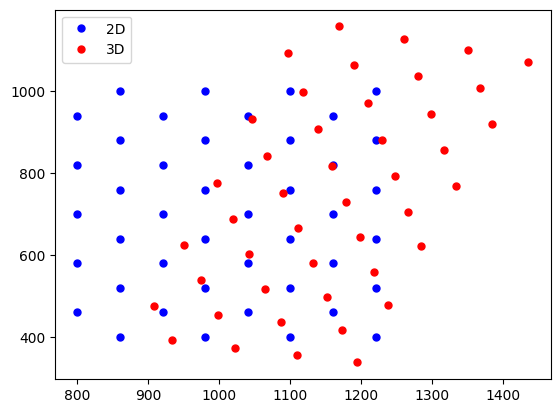

In [785]:
import matplotlib.pyplot as plt
id = -1
rvec_proj, _ = cv2.Rodrigues(proj_R)
pts_3d = obj_pts.copy()
pts_3d[id][:,2] = np.ones_like(pts_3d[id][:,2])
test3, _ = cv2.projectPoints(pts_3d[id], proj_R, proj_T, proj_mtx, proj_dist)

plt.plot(circle_2d[:, 0], circle_2d[:, 1], 'bo', markersize=5)
plt.plot(test3[:, 0, 0], test3[:, 0, 1], 'ro', markersize=5)
#plt.xlim([0, 1920])
#plt.ylim([0, 1080])
plt.legend(['2D', '3D'])
plt.show()

In [481]:
# print(rvecs[id].T)
# print(tvecs[id].T)
i = 2
test = np.array([[obj_pts[id][i][0]], [obj_pts[id][i][1]], [1.0]], dtype=np.float32)


# rTot = rMat @ proj_R 
# rTest, _ = cv2.Rodrigues(rTot) 
# tTot = proj_R @ tvec + proj_T

transCamToProj = proj_R @ proj_T
rvec_proj, _ = cv2.Rodrigues(proj_R)
rMat, _ = cv2.Rodrigues(rvec)
transPlaneToCam = np.linalg.inv(rMat) @ tvec
totalTrans = transCamToProj + transPlaneToCam


# print(rTest.T)
# print(tTot.T)
ttest = test.copy()
ttest[2] = 1

test3, _ = cv2.projectPoints(ttest + totalTrans, (0,0,0), (0,0,0), proj_mtx, proj_dist)
print(test3)
print(circle_2d[i])

[[[5721034.33577861 2458671.59065727]]]
[980 400]


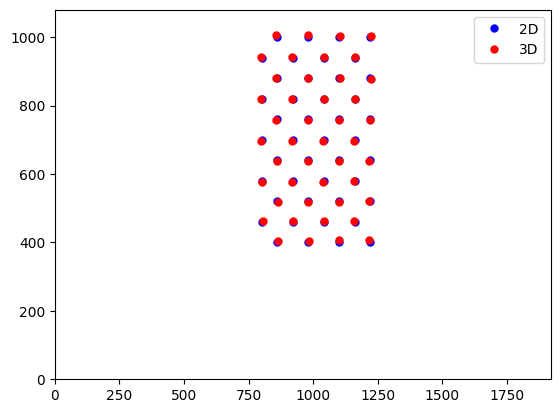

In [764]:
import matplotlib.pyplot as plt
id = 12

circles3D_reprojected, _ = cv2.projectPoints(obj_pts[id], rvecs[id], tvecs[id], proj_mtx, proj_dist)
circles3D_reprojected = circles3D_reprojected[:, 0, :]

plt.plot(circle_2d[:, 0], circle_2d[:, 1], 'bo', markersize=5)
plt.plot(circles3D_reprojected[:, 0], circles3D_reprojected[:, 1], 'ro', markersize=5)
plt.xlim([0, 1920])
plt.ylim([0, 1080])
plt.legend(['2D', '3D'])
plt.show()